In [1]:
pip install torch torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim

# Load the dataset
data = pd.read_csv('Alphabets_data.csv')

# Summarize dataset
print(data.info())
print(data.describe())

# Separate features and target variable
X = data.drop('letter', axis=1)
y = data['letter']

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Create dataset and split into training and test sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Further split the training set into training and validation sets
val_size = int(0.2 * train_size)
train_size = train_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  20000 non-null  object
 1   xbox    20000 non-null  int64 
 2   ybox    20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   height  20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   xbar    20000 non-null  int64 
 7   ybar    20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybar  20000 non-null  int64 
 12  xy2bar  20000 non-null  int64 
 13  xedge   20000 non-null  int64 
 14  xedgey  20000 non-null  int64 
 15  yedge   20000 non-null  int64 
 16  yedgex  20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB
None
               xbox          ybox         width       height         onpix  \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.00000

In [3]:
# Define a basic ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, len(label_encoder.classes_))
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

model = ANN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)


Epoch 1/20, Train Loss: 3.0443, Val Loss: 2.8259, Val Accuracy: 0.5572
Epoch 2/20, Train Loss: 2.7571, Val Loss: 2.7063, Val Accuracy: 0.6444
Epoch 3/20, Train Loss: 2.6885, Val Loss: 2.6553, Val Accuracy: 0.6941
Epoch 4/20, Train Loss: 2.6510, Val Loss: 2.6315, Val Accuracy: 0.7137
Epoch 5/20, Train Loss: 2.6306, Val Loss: 2.6183, Val Accuracy: 0.7175
Epoch 6/20, Train Loss: 2.6176, Val Loss: 2.6096, Val Accuracy: 0.7275
Epoch 7/20, Train Loss: 2.6090, Val Loss: 2.6007, Val Accuracy: 0.7356
Epoch 8/20, Train Loss: 2.6018, Val Loss: 2.5965, Val Accuracy: 0.7362
Epoch 9/20, Train Loss: 2.5961, Val Loss: 2.5935, Val Accuracy: 0.7403
Epoch 10/20, Train Loss: 2.5916, Val Loss: 2.5912, Val Accuracy: 0.7422
Epoch 11/20, Train Loss: 2.5873, Val Loss: 2.5831, Val Accuracy: 0.7491
Epoch 12/20, Train Loss: 2.5830, Val Loss: 2.5802, Val Accuracy: 0.7516
Epoch 13/20, Train Loss: 2.5697, Val Loss: 2.5561, Val Accuracy: 0.7784
Epoch 14/20, Train Loss: 2.5551, Val Loss: 2.5534, Val Accuracy: 0.7781
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

# Define a function to create the model with different hyperparameters
def create_model(input_dim, num_hidden_layers, num_neurons, activation_func, output_dim):
    layers = []
    layers.append(nn.Linear(input_dim, num_neurons))
    layers.append(activation_func())
    for _ in range(num_hidden_layers - 1):
        layers.append(nn.Linear(num_neurons, num_neurons))
        layers.append(activation_func())
    layers.append(nn.Linear(num_neurons, output_dim))
    layers.append(nn.Softmax(dim=1))
    return nn.Sequential(*layers)

# Define hyperparameters grid
param_grid = {
    'num_hidden_layers': [1, 2, 3],
    'num_neurons': [32, 64, 128],
    'activation_func': [nn.ReLU, nn.Tanh],
    'learning_rate': [0.001, 0.0001]
}

best_model = None
best_accuracy = 0
best_params = {}

# Perform grid search
for params in ParameterGrid(param_grid):
    model = create_model(X.shape[1], params['num_hidden_layers'], params['num_neurons'], params['activation_func'], len(label_encoder.classes_))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    # Evaluate the model on the validation set
    val_accuracy = evaluate_model(model, val_loader)
    print(f"Parameters: {params}, Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        best_params = params

print(f"Best parameters: {best_params}, Best validation accuracy: {best_accuracy:.4f}")


Epoch 1/10, Train Loss: 3.1304, Val Loss: 2.9506, Val Accuracy: 0.4422
Epoch 2/10, Train Loss: 2.8404, Val Loss: 2.7526, Val Accuracy: 0.6644
Epoch 3/10, Train Loss: 2.7100, Val Loss: 2.6745, Val Accuracy: 0.7244
Epoch 4/10, Train Loss: 2.6534, Val Loss: 2.6369, Val Accuracy: 0.7428
Epoch 5/10, Train Loss: 2.6223, Val Loss: 2.6125, Val Accuracy: 0.7616
Epoch 6/10, Train Loss: 2.5988, Val Loss: 2.5900, Val Accuracy: 0.7794
Epoch 7/10, Train Loss: 2.5803, Val Loss: 2.5753, Val Accuracy: 0.7891
Epoch 8/10, Train Loss: 2.5664, Val Loss: 2.5634, Val Accuracy: 0.7984
Epoch 9/10, Train Loss: 2.5557, Val Loss: 2.5545, Val Accuracy: 0.8016
Epoch 10/10, Train Loss: 2.5471, Val Loss: 2.5476, Val Accuracy: 0.8053
Parameters: {'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'learning_rate': 0.001, 'num_hidden_layers': 1, 'num_neurons': 32}, Validation Accuracy: 0.8053
Epoch 1/10, Train Loss: 3.0575, Val Loss: 2.8384, Val Accuracy: 0.5837
Epoch 2/10, Train Loss: 2.7508, Val Loss: 2.68

In [8]:
import torch
from sklearn.metrics import classification_report

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    return accuracy

# Ensure best_model is not None
if best_model is not None:
    # Evaluate the best model on the test set
    test_accuracy = evaluate_model(best_model, test_loader)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Get predictions and ground truths
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = best_model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(predicted.tolist())

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
else:
    print("No best model found. Please check the hyperparameter tuning process.")


Test Accuracy: 0.8485
              precision    recall  f1-score   support

           A       0.91      0.88      0.89       144
           B       0.71      0.91      0.80       155
           C       0.99      0.71      0.83       139
           D       0.91      0.84      0.87       161
           E       0.73      0.85      0.78       146
           F       0.89      0.84      0.87       164
           G       0.70      0.88      0.78       148
           H       0.74      0.49      0.59       148
           I       0.83      0.84      0.84       129
           J       0.95      0.83      0.89       135
           K       0.83      0.88      0.86       147
           L       0.93      0.88      0.90       145
           M       0.95      0.93      0.94       192
           N       0.80      0.89      0.84       166
           O       0.77      0.85      0.81       154
           P       0.90      0.89      0.89       171
           Q       0.75      0.97      0.85       155
     

In [11]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        val_accuracy = correct / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, val_accuracies

# Example usage:
# train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)


In [ ]:
# Perform grid search with visualization
best_model = None
best_accuracy = 0
best_params = {}
all_train_losses = []
all_val_losses = []
all_val_accuracies = []

for params in ParameterGrid(param_grid):
    model = create_model(X.shape[1], params['num_hidden_layers'], params['num_neurons'], params['activation_func'], len(label_encoder.classes_))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    # Train the model
    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_val_accuracies.append(val_accuracies)

    # Evaluate the model on the validation set
    val_accuracy = val_accuracies[-1]
    print(f"Parameters: {params}, Validation Accuracy: {val_accuracy:.4f}")


# Plotting training and validation losses
plt.figure(figsize=(14, 7))
for i, params in enumerate(ParameterGrid(param_grid)):
    plt.plot(all_train_losses[i], label=f'Train Loss {params}')
    plt.plot(all_val_losses[i], label=f'Val Loss {params}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Hyperparameters')
plt.legend()
plt.show()


Epoch 1/10, Train Loss: 3.1299, Val Loss: 2.9608, Val Accuracy: 0.4219
Epoch 2/10, Train Loss: 2.8483, Val Loss: 2.7613, Val Accuracy: 0.6444
Epoch 3/10, Train Loss: 2.7209, Val Loss: 2.6820, Val Accuracy: 0.7122
Epoch 4/10, Train Loss: 2.6563, Val Loss: 2.6380, Val Accuracy: 0.7400
Epoch 5/10, Train Loss: 2.6210, Val Loss: 2.6114, Val Accuracy: 0.7569
Epoch 6/10, Train Loss: 2.5989, Val Loss: 2.5928, Val Accuracy: 0.7725
Epoch 7/10, Train Loss: 2.5828, Val Loss: 2.5782, Val Accuracy: 0.7809
Epoch 8/10, Train Loss: 2.5709, Val Loss: 2.5689, Val Accuracy: 0.7850
Epoch 9/10, Train Loss: 2.5612, Val Loss: 2.5611, Val Accuracy: 0.7956
Epoch 10/10, Train Loss: 2.5531, Val Loss: 2.5538, Val Accuracy: 0.7969
Parameters: {'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'learning_rate': 0.001, 'num_hidden_layers': 1, 'num_neurons': 32}, Validation Accuracy: 0.7969
Epoch 1/10, Train Loss: 3.0404, Val Loss: 2.8226, Val Accuracy: 0.5956
Epoch 2/10, Train Loss: 2.7380, Val Loss: 2.67

Test Accuracy: 0.8405
              precision    recall  f1-score   support

           A       0.85      0.85      0.85       144
           B       0.72      0.92      0.80       155
           C       1.00      0.70      0.82       139
           D       0.87      0.80      0.83       161
           E       0.75      0.79      0.77       146
           F       0.85      0.86      0.85       164
           G       0.74      0.80      0.77       148
           H       1.00      0.28      0.43       148
           I       0.82      0.87      0.85       129
           J       0.96      0.80      0.87       135
           K       0.61      0.89      0.72       147
           L       0.96      0.88      0.92       145
           M       0.93      0.94      0.94       192
           N       0.90      0.91      0.91       166
           O       0.77      0.84      0.80       154
           P       0.90      0.86      0.88       171
           Q       0.80      0.93      0.86       155
     

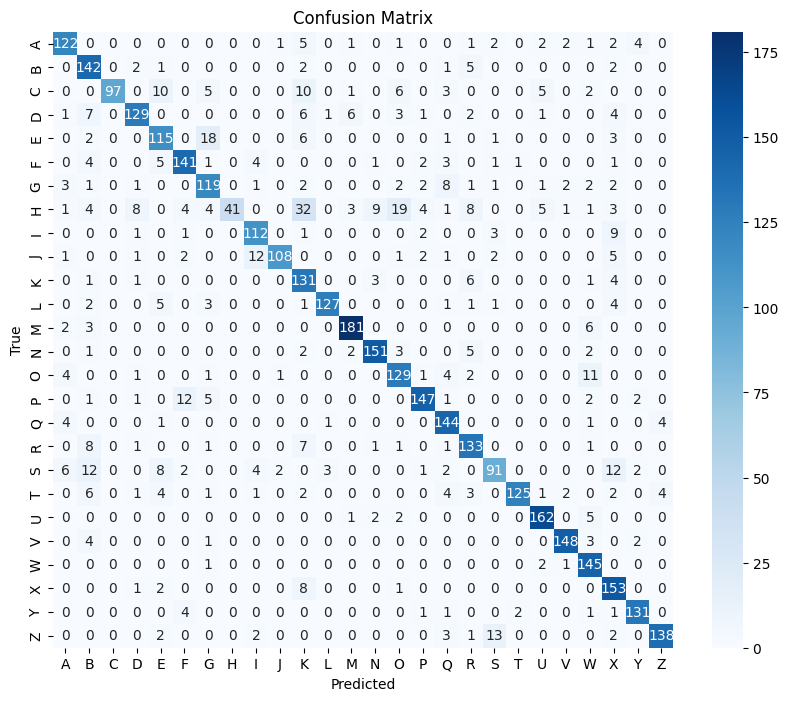

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure best_model is not None
if best_model is not None:
    # Evaluate the best model on the test set
    test_accuracy = evaluate_model(best_model, test_loader)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Get predictions and ground truths
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = best_model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(predicted.tolist())

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("No best model found. Please check the hyperparameter tuning process.")


C:\Users\MY PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2997 - loss: 2.5494 - val_accuracy: 0.6703 - val_loss: 1.1701
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7136 - loss: 1.0297 - val_accuracy: 0.7559 - val_loss: 0.8473
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7769 - loss: 0.7573 - val_accuracy: 0.7909 - val_loss: 0.7063
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8117 - loss: 0.6490 - val_accuracy: 0.8263 - val_loss: 0.6238
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8371 - loss: 0.5487 - val_accuracy: 0.8378 - val_loss: 0.5618
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8568 - loss: 0.4956 - val_accuracy: 0.8562 - val_loss: 0.5109
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8644 - loss: 0.4583 - val_accuracy: 0.8594 - val_loss: 0.4757
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.4143 - val_accuracy: 0.

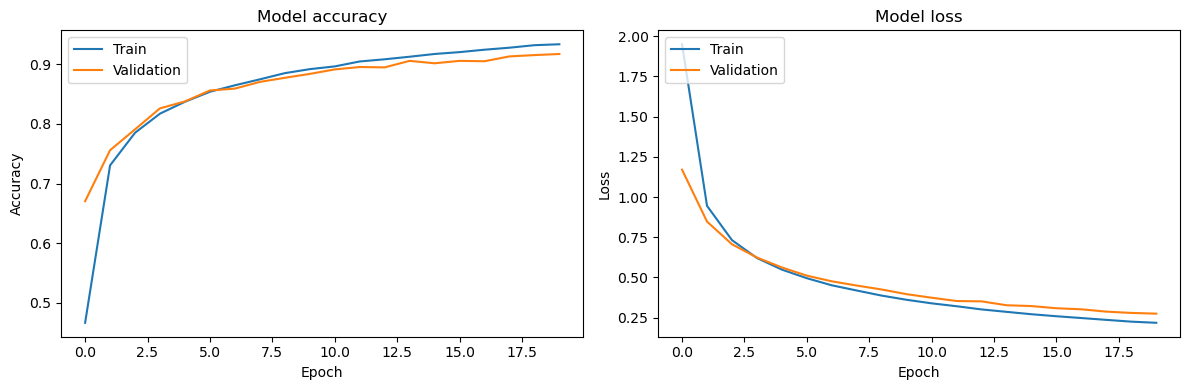

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Alphabets_data.csv'
df = pd.read_csv(file_path)

# Separate features and target variable
X = df.drop('letter', axis=1)
y = df['letter']

# Normalize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the categorical target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Construct a basic ANN model
model = Sequential()
model.add(Dense(64, input_dim=16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(26, activation='softmax'))  # 26 output classes for each letter

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


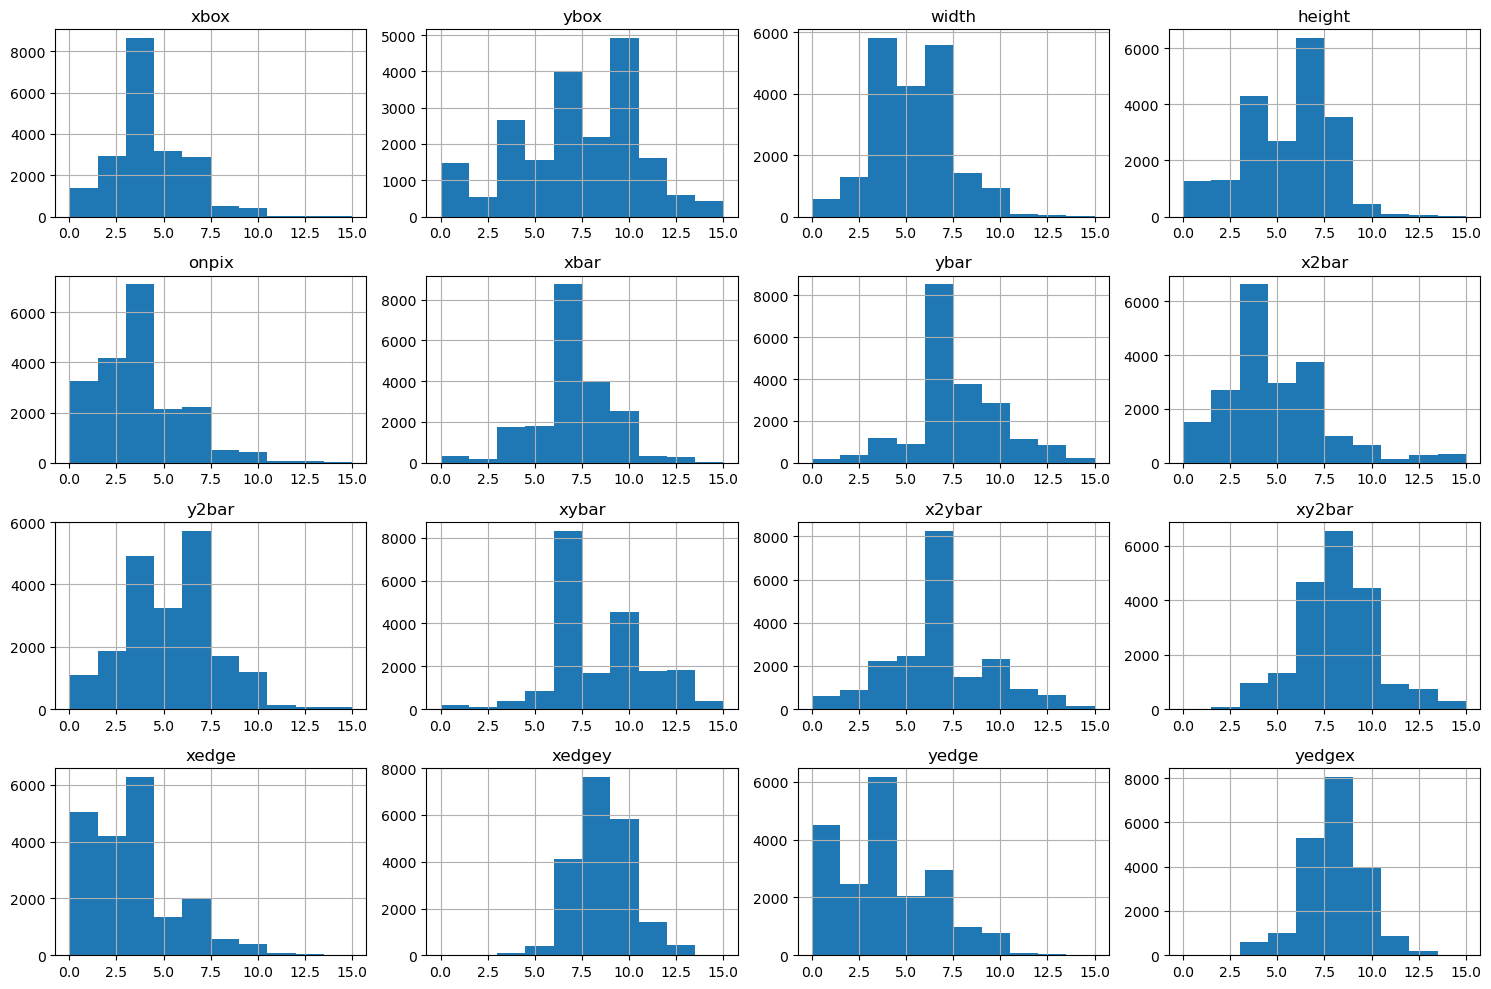

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('Alphabets_data.csv')

# Plot histograms for each feature
data.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


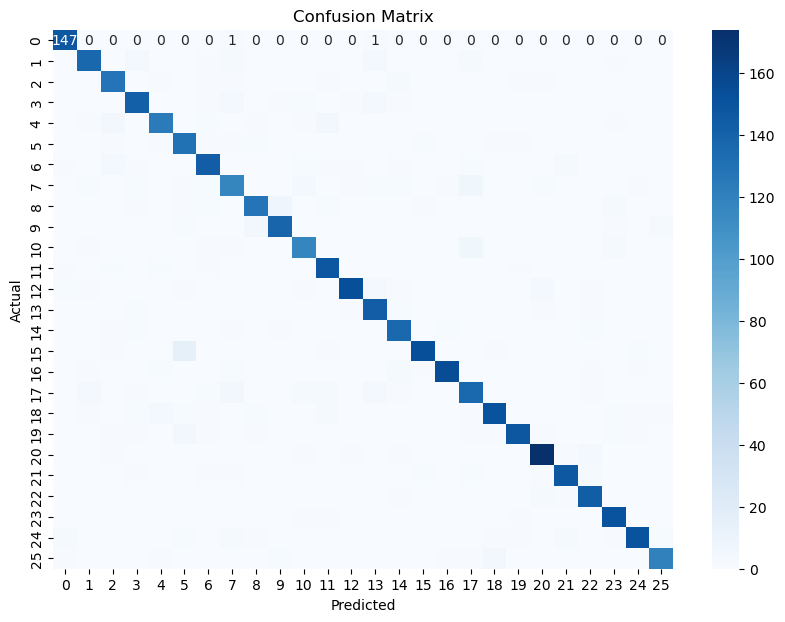

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


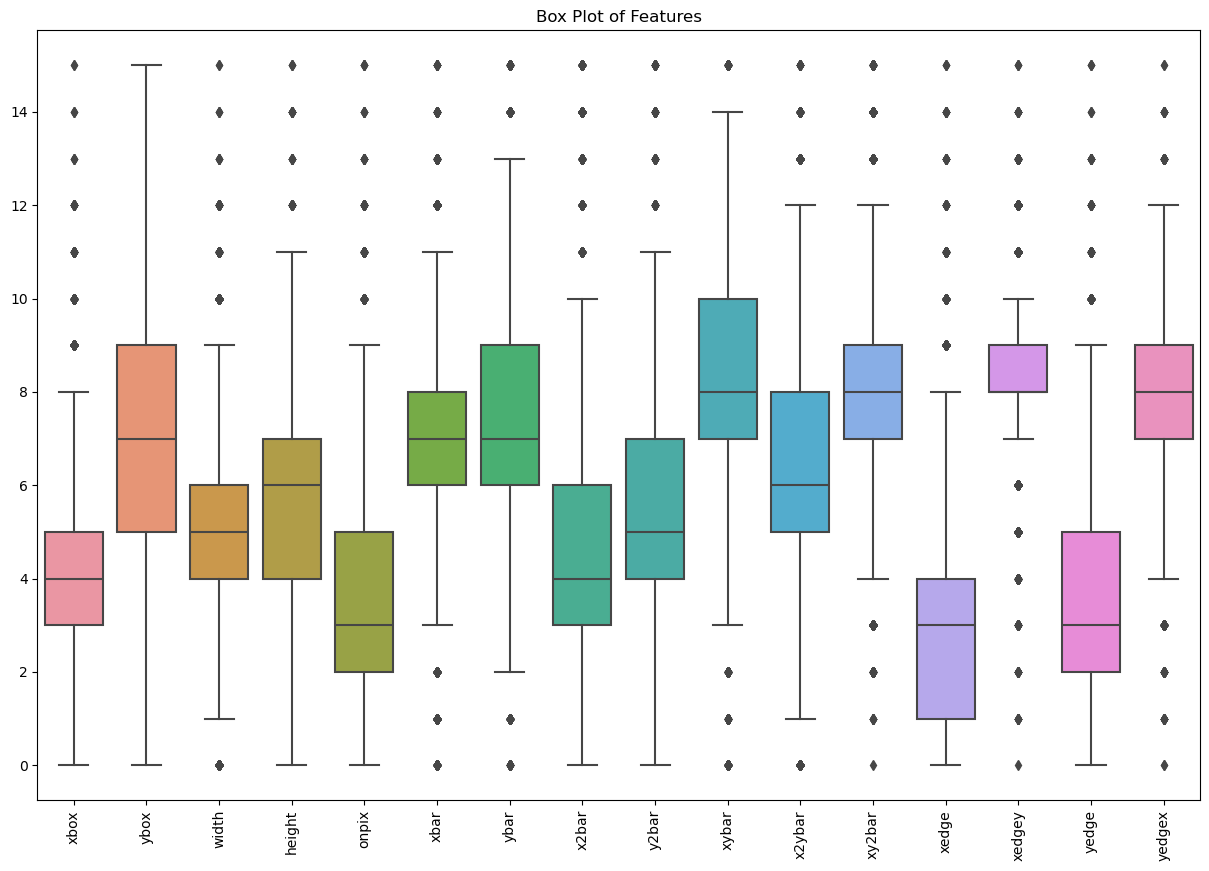

In [24]:
# Box plots for each feature
plt.figure(figsize=(15, 10))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.title('Box Plot of Features')
plt.show()


C:\Users\MY PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\MY PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\MY PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\MY PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

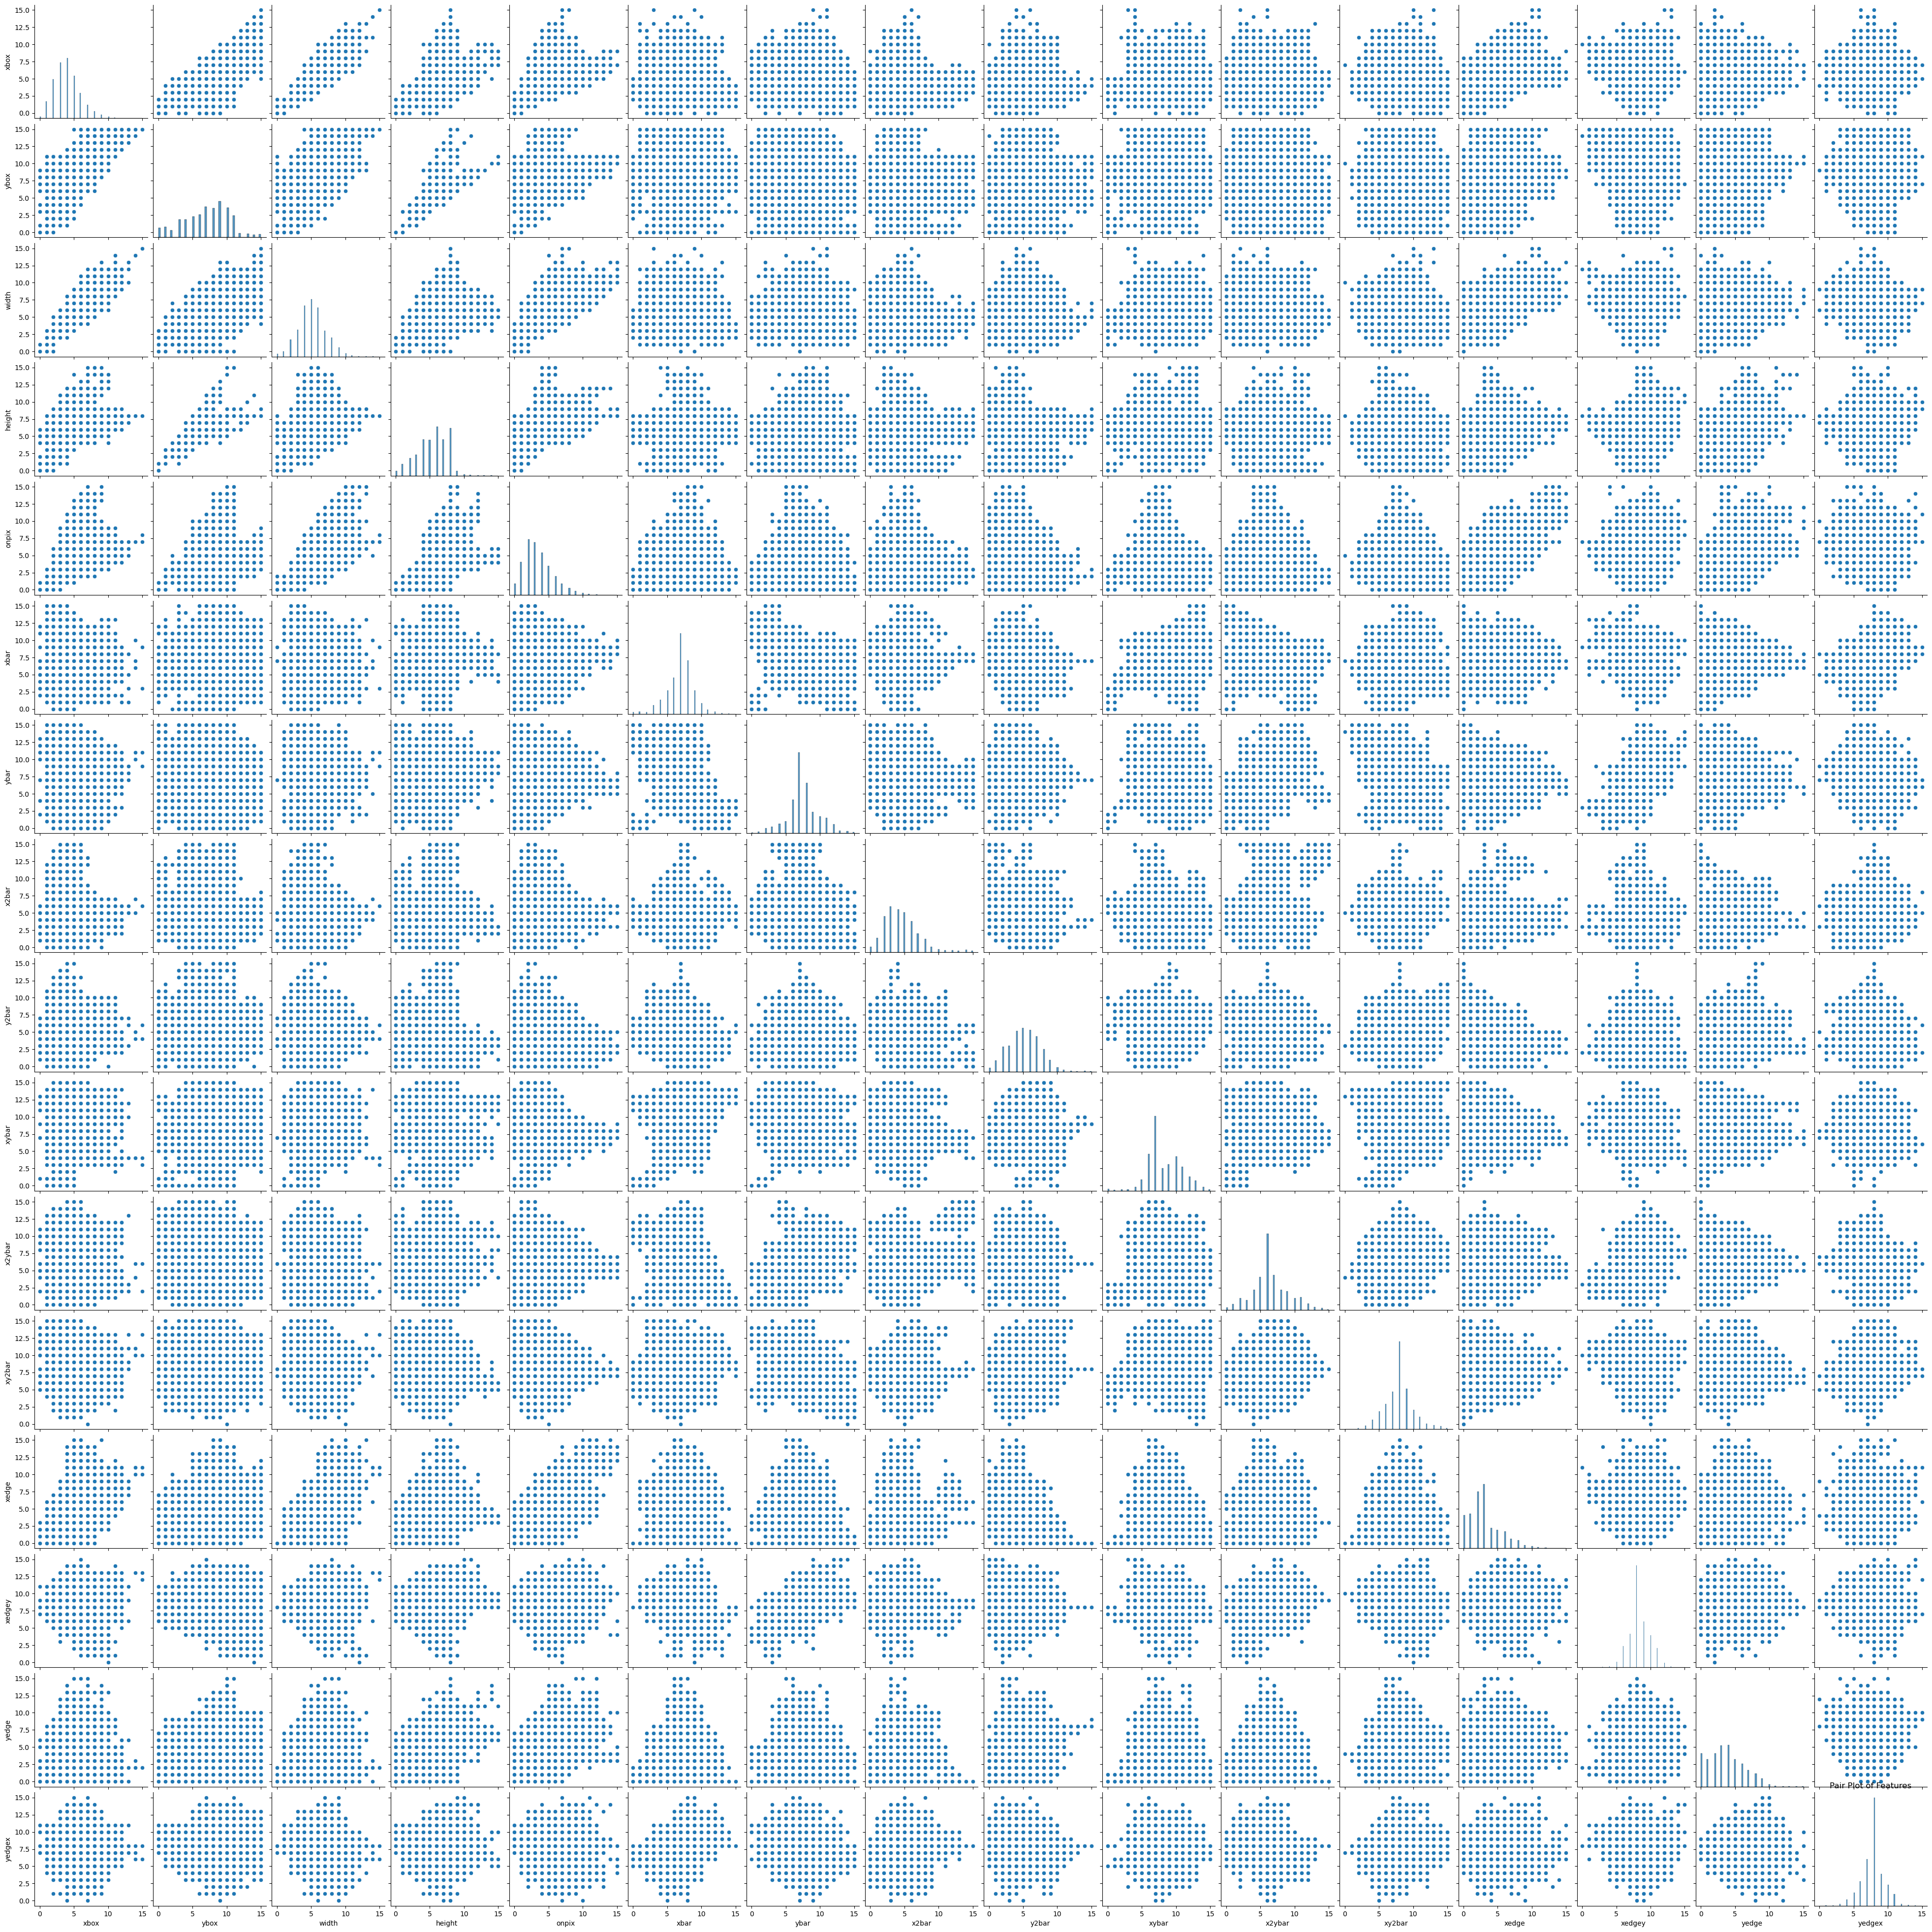

In [26]:
# Pair plot to visualize relationships between features
sns.pairplot(data)
plt.title('Pair Plot of Features')
plt.show()
